In [12]:
import os
import imp
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import sys
import pickle as plk
import importlib.util

###############################################################
# LINUX PATH

sys.path.append("/opt/lumerical/v221/api/python/") #Default linux lumapi path
import lumapi
sys.path.append(os.path.dirname('/home/trainner/Documentos/Bruno/git/Photonics-main')) #Current directory


###############################################################
# WINDOWS PATH

#spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
#lumapi = importlib.util.module_from_spec(spec_win)
#os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
#sys.path.append(os.path.dirname('C:/Users/Bruno Nascimento/OneDrive/Documentos/GitHub/Photonics'))
#spec_win.loader.exec_module(lumapi)

mmi = lumapi.MODE() 

# FUNÇÃO : ADD RET


In [13]:
def AddRect(Nome , x_span,XSET, y_span,YSET, z_span):

    mmi.switchtolayout()
    mmi.addrect()

    mmi.set({'name':Nome , 'material': 'Si (Silicon) - Palik', 'x span': x_span, 'x':XSET,
    'y span': y_span, 'y':YSET , 'z span':z_span , 'z':0})


# ADD TAPER


In [14]:
def AddTapper(Nome, W_L, W_R,len,X,Y,Z):

    mmi.switchtolayout()
    mmi.addobject("linear_taper")
    
    mmi.set({'name':Nome,'material': 'Si (Silicon) - Palik', 'angle_side':90, 'width_l': W_L, 'width_r':W_R,
    'len':len, 'x':X, 'y':Y,'thickness':0.22e-6,'z':Z})

# ADD PORTS 

In [15]:
def AddPort(Nome, Y, y_span,Side):

    mmi.switchtolayout()

    mmi.addemeport()

    mmi.set({
    'name':Nome,
    'y':Y,
    'y span':y_span,
    'port location':Side,
    "use full simulation span":False
    })


# ADD MESH

In [16]:
def AddMesh(Estrutura):

    mmi.switchtolayout()

    mmi.addmesh()

    mmi.set({
        'based on a structure':True,
        'structure':Estrutura,
        'set mesh multiplier':True,
        'override x mesh':True,
        'override y mesh':True,
        'override z mesh':True,

        'x mesh multiplier':5,
        'y mesh multiplier':5

    })
    

# DELETE RET 


In [17]:
def DelRet(Nome):
    mmi.setnamed(Nome)
    mmi.delete()

# Construção 


In [18]:
mmi.switchtolayout()
mmi.deleteall()

# Construindo a Box
xb_span = 28.125e-6
yb_span = 9e-6
zb_span = 0.22e-6
AddRect('Box', xb_span , xb_span/2, yb_span, 0, zb_span)


#Construindo Taper(Saída)

w_l = 1.33e-6
w_r = 0.45e-6
size_taper = 4e-6
set_y = [3.5e-6, 1.82e-6, 0, -1.82e-6, -3.5e-6]

set_z = 0

#Construindo os Outputs

y_s = 0.45e-6
x_s = 4e-6
Quant = 5
set_x = xb_span + size_taper + (x_s/2)

AddRect('Out_1',x_s, set_x ,y_s,set_y[0],zb_span)
AddRect('Out_2',x_s, set_x ,y_s,set_y[1],zb_span)
AddRect('Out_3',x_s, set_x ,y_s,set_y[2],zb_span)
AddRect('Out_4',x_s, set_x ,y_s,set_y[3],zb_span)
AddRect('Out_5',x_s, set_x ,y_s,set_y[4],zb_span)

AddTapper('Tap_1',w_l,w_r,size_taper,xb_span+(size_taper/2),set_y[0],0)
AddTapper('Tap_2',w_l,w_r,size_taper,xb_span+(size_taper/2),set_y[1],0)
AddTapper('Tap_3',w_l,w_r,size_taper,xb_span+(size_taper/2),set_y[2],0)
AddTapper('Tap_4',w_l,w_r,size_taper,xb_span+(size_taper/2),set_y[3],0)
AddTapper('Tap_5',w_l,w_r,size_taper,xb_span+(size_taper/2),set_y[4],0)

#Construindo input

AddRect('In',x_s,(-x_s/2-size_taper) ,0.45e-6,0,zb_span)

AddTapper('Tap_in',w_r,w_l-0.01e-6,size_taper,-size_taper/2,0,0)

#Adicionando o EME

c = mmi.getnamed('Out_2','x min')

v = (mmi.getnamed('In','x min') + mmi.getnamed('In','x max'))/2

mmi.switchtolayout()
mmi.addeme()

mmi.set({"allow custom eigensolver settings":1 ,"display cells":1, "number of cell groups":3,
         "group spans": np.transpose([size_taper+(4e-6/2), xb_span, size_taper+(4e-6/2)]),
         "cells":np.transpose([3, 1, 3]),
         "subcell method":np.transpose([1, 0, 1]), # 0 = none,  1 = CVCS
         "modes":np.transpose([10, 50, 10])})

mmi.set({"x min":v ,
     "y":0, "y span":1.8*yb_span,
     "z":0, "z span":1e-6})

mmi.set({"y min bc":"PML", "y max bc":"PML",
     "z min bc":"Symmetric", "z max bc":"PML",
     "background material": "SiO2 (Glass) - Palik",
     "mesh cells y":500, "mesh cells z":500})


#Adicionando as Portas

mmi.selectpartial("EME::Ports::port")
mmi.delete()

aumento = 1e-6
AddPort('port_1', 0 , y_s + aumento + 1e-6, 'left')
AddPort('port_2',set_y[0], y_s + aumento - 0.05e-6, 'right')
AddPort('port_3',set_y[1], y_s + aumento - 0.05e-6, 'right')
AddPort('port_4',set_y[2], y_s + aumento - 0.05e-6, 'right')
AddPort('port_5',set_y[3], y_s + aumento - 0.05e-6, 'right')
AddPort('port_6',set_y[4], y_s + aumento - 0.05e-6, 'right')

#Adicionando Monitor
mmi.addemeprofile()

mmi.set({
     'x min': mmi.getnamed('EME', 'x min'),
     'x max':  xb_span + size_taper + x_s/2,
     'y span': 1.8*yb_span
})

AddMesh('Tap_in')
AddMesh('Tap_1')
AddMesh('Tap_2')
AddMesh('Tap_3')
AddMesh('Tap_4')
AddMesh('Tap_5')






{!!}

{!!}

{!!}

{!!}

{!!}



# Soma 

In [82]:
#mmi.run()
#mmi.emepropagate()
soma = 0
m =np.array
index = 1
for i in range(5):
    index = index 
    m = mmi.getresult('EME','user s matrix')

    soma = soma + abs(m[index,0])**2

    index = index + 1
   

soma_db = 10*math.log10(soma)

print('A soma é de:',soma,'\n')


print('A perda em dB é de:',soma_db,'\n')








A soma é de: 0.9088683404267374 

A perda em dB é de: -0.41499024553019437 



# Sweep

Na  0 interação, temos que a transmissão é de:  -0.5651388668579311
Na  1 interação, temos que a transmissão é de:  -0.5867187981106852
Na  2 interação, temos que a transmissão é de:  -0.722677355967582
Na  3 interação, temos que a transmissão é de:  -0.5806378852842246
Na  4 interação, temos que a transmissão é de:  -0.4937133556007669
Na  5 interação, temos que a transmissão é de:  -0.5398746627658817


Text(0.5, 1.0, 'Transmission X W_L')

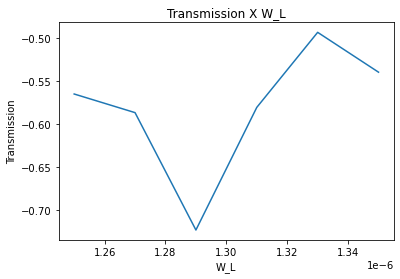

In [9]:


x = np.linspace(1.25e-6, 1.35e-6, 6)
 



re = np.zeros(6)

for i in range (6):
    mmi.switchtolayout()

    soma = 0
    m =np.array

    mmi.setnamed('Tap_1','width_l', x[i])
    mmi.setnamed('Tap_2','width_l', x[i])
    mmi.setnamed('Tap_3','width_l', x[i])
    mmi.setnamed('Tap_4','width_l', x[i])
    mmi.setnamed('Tap_5','width_l', x[i])

    mmi.run()
    mmi.emepropagate()
  
    index = 1
    for j in range (5):
        m = mmi.getresult('EME','user s matrix')

        soma = soma + abs(m[index,0])**2

        index = index + 1
    
    soma_db = 10*math.log10(soma)

    re[i] = soma_db
    print('Na ' ,i, 'interação, temos que a transmissão é de: ',soma_db)



plt.plot(x, re)

plt.xlabel('W_L')
plt.ylabel('Transmission')

plt.title('Transmission X W_L')



# Teste Sweep Tds os Tappers

In [ ]:
x = np.linspace(1.2e-6, 1.35e-6, 6)

y = np.linspace(1.2e-6, 1.35e-6, 6)



re = np.zeros(6)

for j in range (6):
    mmi.switchtolayout()
    mmi.setnamed('Tap_in','width_r',y[j])
    for i in range (6):
        mmi.switchtolayout()

        soma = 0
        m =np.array
        index = 0

        mmi.setnamed('Tap_1','width_l', x[i])
        mmi.setnamed('Tap_2','width_l', x[i])
        mmi.setnamed('Tap_3','width_l', x[i])
        mmi.setnamed('Tap_4','width_l', x[i])
        mmi.setnamed('Tap_5','width_l', x[i])

        mmi.run()
        mmi.emepropagate()
  

    for j in range (6):
        index = index 
        m = mmi.getresult('EME','user s matrix')

        soma = soma + abs(m[i,0])**2
    
    soma_db = 10*math.log10(soma)

    re[i] = soma_db

    plt.plot(x, re, 'Width_l', 'Transmissão', title = 'Para y(j)')

# Teste

In [33]:
m = mmi.getresult('EME','user s matrix')

print(abs(m[0,0])**2)

8.594929501924322e-07
